In [124]:
from astropy import units as u
from astropy.constants import codata2018 as const
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pandas as pd

# Physical Parameter: Planet Radius

# Instrument: telescope size

Limitation: diffraction limit $\implies$ telescope radius. From Currie 2023, equation (1)

$$\theta\left({ }^{\prime \prime}\right)_{\mathrm{FWHM}} \sim 0.21\left(\frac{\lambda(\mu m)}{D_{\text {tel }}(m)}\right)$$

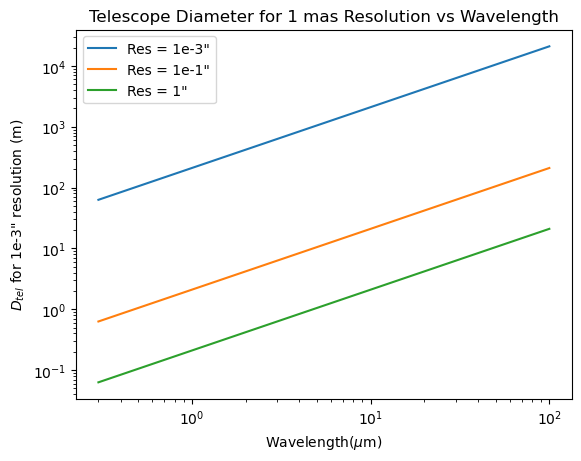

In [8]:
lam = np.linspace(0.3, 100, 3000) # wavelength from visible to mid-IR 
th = 0.001 # angluar resolution in arcseconds
dtel = 0.21*lam/th # telescope diameter in meters
plt.loglog(lam, dtel, label = "Res = 1e-3\"")
plt.loglog(lam, dtel/100, label = "Res = 1e-1\"")
plt.loglog(lam, dtel/1000, label = "Res = 1\"")
plt.xlabel("Wavelength($\\mu\\text{m}$)")
plt.ylabel("$D_{tel}$ for 1e-3\" resolution (m)")
plt.title("Telescope Diameter for 1 mas Resolution vs Wavelength")
plt.legend()
plt.show()

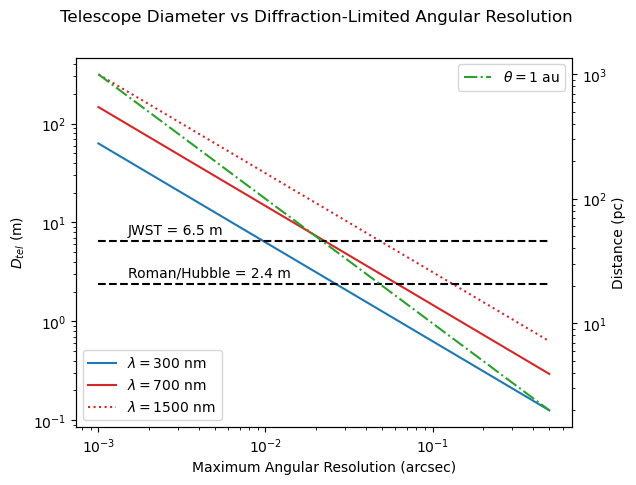

In [10]:
lam7 = 0.7
lam3 = 0.3
lam15 = 1.5
th = np.linspace(0.001, 0.5, 100)
dtel3 = 0.21*lam3/th
dtel7 = 0.21*lam7/th
dtel15 = 0.21*lam15/th
fig, ax1 = plt.subplots()
ax1.plot(th, dtel3, color="tab:blue", label= "$\\lambda = 300$ nm")
ax1.plot(th, dtel7, color="tab:red", label = "$\\lambda = 700$ nm")
ax1.plot(th, dtel15, color="tab:red", ls=":", label = "$\\lambda = 1500$ nm")

ax1.hlines(y = [2.4, 6.5] , xmin = 0.001, xmax = 0.5, ls="--", color="k")
ax1.text(0.0015, 7.5, "JWST = 6.5 m")
ax1.text(0.0015, 2.8, "Roman/Hubble = 2.4 m")

ax1.set_xlabel("Maximum Angular Resolution (arcsec)")
ax1.set_ylabel("$D_{tel}$ (m)")

pc = 206265.0 # pc->au
OneAuAtDistance = 180*3600/(np.pi * th * pc)
ptOneAu = OneAuAtDistance /10
tenAu = OneAuAtDistance * 10
ax2 = ax1.twinx()
ax2.plot(th, OneAuAtDistance, color="tab:green", ls="-.", label="$\\theta = 1$ au")
# ax2.fill_between(th, ptOneAu, tenAu, color = "tab:gray", alpha=0.1)

ax2.set_ylabel("Distance (pc)")
ax2.legend()

ax1.set_yscale("log")
ax1.set_xscale("log")
ax2.set_yscale("log")

fig.suptitle("Telescope Diameter vs Diffraction-Limited Angular Resolution")
ax1.legend(loc="lower left")
fig.savefig("diameter_vs_res.png")
plt.show()

# Instrument: Coronagraph Inner Working Angle

* We need to see 0.7 au at 20 pc

In [13]:
minOrbit = 0.7*u.au
maxSystemDistance = 20*u.pc
iwa = minOrbit/maxSystemDistance
iwa = iwa.si # to radians
iwa = iwa * (180/np.pi) * 3600 * 1000 # to mas
print("IWA = {} mas".format(iwa))

IWA = 34.99999999999999 mas


# Instrument: Angular Resolution

Looking at planets with orbital period >200 days. Use Kepler's 3rd law ($T^2 \propto a^3$) with Earth as a baseline to determine a reasonable orbital separation:

In [17]:
t_earth  = 365.25 #days
t_target = 200.0 #days
a_earth  = 1.0 #au
a_target = a_earth*(t_target/t_earth)**(2/3)
print("A planet with an orbital period of {} days will have a SMA of {:.2f} au.".format(t_target, a_target))

A planet with an orbital period of 200.0 days will have a SMA of 0.67 au.


At 20 parsecs, 0.5 au subtends an angle of

In [20]:
angular_res = 0.5*u.au/(20*u.pc)
angular_res = angular_res.to(u.dimensionless_unscaled).value
print("{} mas".format(angular_res * (180/np.pi) * 3600 * 1000))

25.000000000000004 mas


# Instrument: Field of View

Driven by largest orbit to observe in closest system

In [23]:
aLargest = 20*u.au # ~6 au x3
dClosest = 1.3*u.pc
fov = 2*aLargest/dClosest
fov = fov.si # in radians
((fov * 180/np.pi)*60) # sq arc-minutes

<Quantity 0.51282051>

# Observable: Flux

In [26]:
def planckSpectralRadianceVsWavelength(lam, temp):
    """
    Calculates spectral radiance (B_lambda) of a blackbody.

    Args:
        lam (Quantity): Wavelength(s) with units (e.g., 500*u.nm).
        temp (Quantity): Temperature with units (e.g., 5800*u.K).

    Returns:
        float or array: Spectral radiance in SI units (W / (m^2 sr m)).
    """
    l = lam.si.value
    t = temp.si.value
    h = const.h.si.value
    k = const.k_B.si.value
    c = const.c.si.value
    coeff = 2.0 * h * c**2/l**5
    exponent = h * c / (k * t * l)
    out = coeff / np.expm1(exponent)
    return out

In [28]:
def radiantFluxBandpass(temp, lamMin, lamMax):
    """
    Calculates the radiant flux by integrating Planck's Law.
    """
    wavelengths = np.logspace(np.log10(lamMin.si.value), np.log10(lamMax.si.value), 500) * u.m
    integrand = planckSpectralRadianceVsWavelength(wavelengths, temp)
    out = np.pi * integrate.trapezoid(integrand, x=wavelengths.si.value)
    return out

In [30]:
def luminosityBandpass(temp, radius, lamMin, lamMax):
    """
    Calculates the luminosity from the radiant flux and radius.
    """
    M = radiantFluxBandpass(temp, lamMin, lamMax)
    surfaceArea = 4 * np.pi * radius**2
    surfaceArea = surfaceArea.si.value
    L = M * surfaceArea
    return L

In [32]:
def luminositySB(temp, radius):
    """
    Calculates the luminosity of a blackbody using the Stefan Boltzmann law
    """
    sigma = const.sigma_sb.si.value
    out = 4 * np.pi * radius.si.value**2 * sigma * temp.si.value**4
    return out

In [34]:
def blackBodyTemp(incidentFlux, emissivity = 1.0):
    sigma = const.sigma_sb.si.value
    return (incidentFlux/(emissivity*sigma))**0.25

Currie 2023 gives the following definition for contrast:
$$
C_{\mathrm{IR}, \lambda} \sim \frac{F_{\lambda, p}(T, X) r_{\mathrm{p}}^2}{F_{\lambda, s}(T) r_{\mathrm{s}}^2}
$$
Let's figure out what we can see!

In [37]:
# the X-axis will be the orbital period in days
tOrbit = np.logspace(0, 2, 500)
# use K3L to convert into a distance approximation (in AU)
dOrbit = (tOrbit/365.25)**(2/3)

In [39]:
# the flux of the star assuming size & surface temp similar to the sun
lamMin = 750  * u.nanometer
lamMax = 2500 * u.nanometer
tempStar = 5800 * u.K
rStar = 7e5*u.km
fStar = radiantFluxBandpass(tempStar, lamMin, lamMax)
fStar

27289067.3089739

In [41]:
# double check: actual solar luminosity is ~3.86e26 Watts
radiantFluxBandpass(5800*u.K, 10*u.nanometer, 1e6*u.nanometer) * 4 * np.pi * rStar.si.value**2

3.951556394176124e+26

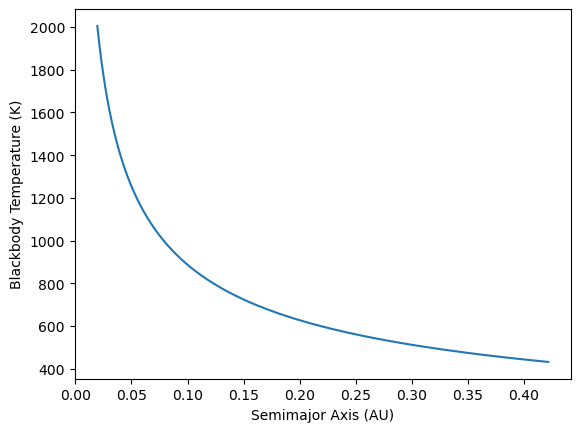

In [43]:
# let's get the black body temp as a function of distance to the star
## use SB law to get total luminosity
lstar = luminositySB(5800*u.K, 7e5*u.km)
# get the distance in SI
dOrbitM = dOrbit * u.au
dOrbitM = dOrbitM.si.value # distance to star in meters
bbTemp = blackBodyTemp(lstar/(16*np.pi*dOrbitM**2))
plt.plot(dOrbit, bbTemp)
plt.xlabel("Semimajor Axis (AU)")
plt.ylabel("Blackbody Temperature (K)")
plt.show()

In [876]:
# get the flux of the planet in the given band based on the BB temp
fPlanet = np.array([radiantFluxBandpass(temp * u.K, lamMin, lamMax) for temp in bbTemp])

In [878]:
# define our radii
rSuperEarth = const.R_earth * 1.5
rSuperEarth = rSuperEarth.si.value
rJup = const.R_jup.si.value

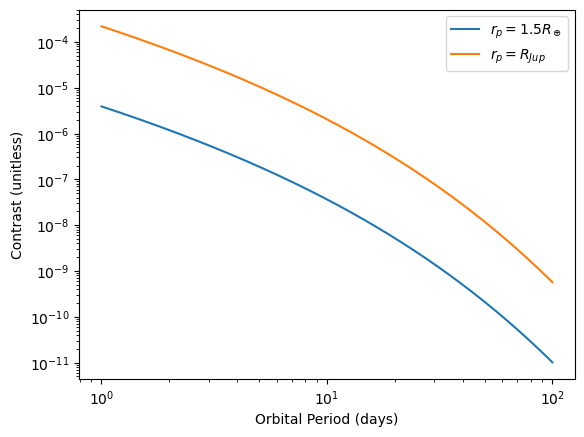

In [883]:
contrastSuperEarth = fPlanet * rSuperEarth**2
contrastSuperEarth = contrastSuperEarth / fStar
contrastSuperEarth = contrastSuperEarth / rStar.si.value**2

contrastJup = fPlanet * rJup**2
contrastJup = contrastJup / fStar
contrastJup = contrastJup / rStar.si.value**2

fig, ax = plt.subplots()
ax.plot(tOrbit, contrastSuperEarth, label = "$r_p = 1.5R_\\oplus$")
ax.plot(tOrbit, contrastJup, label = "$r_p = R_{Jup}$")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Contrast (unitless)")
ax.set_xlabel("Orbital Period (days)")
ax.legend()
# fig.suptitle("Planet emissivity")
plt.show()

## Planet Luminosity and Contrast as a Function of Stellar Luminosity

In [99]:
def scalarLuminosityToMass(lstar):
    """
    Calculates the stellar from the luminosity based on Halm's relation (see the Wikipedia article https://en.wikipedia.org/wiki/Mass-luminosity_relation and references therein).

    Args:
        lstar (number): Luminosity in units of $L_\\odot$.

    Returns:
        Stellar mass (number): Mass in units of $M_\\odot$.
    """
    if lstar < 0.0:
        return 0.0
    elif lstar < 0.03418801:
        return (lstar/0.23817511001034142)**(1/2.3)
    elif lstar < 16.0:
        return (lstar)**(1/4)
    elif lstar < 1744956:
        return (lstar/np.sqrt(2))**(1/3.5)
    else:
        return lstar/3.2e5
        
luminosityToMass = np.vectorize(scalarLuminosityToMass)

In [221]:
def distanceToHostStar(period, mstar):
    """
    Calculate radius of a circular orbit around a star of mass `mstar` and duration of `period`.

    Args:
        period (Quantity): period of the orbit in days
        mstar (Quantity): stellar mass

    Returns:
        Radius of the orbit in au
    """

    out = (const.G * mstar * period**2/(4*np.pi**2))
    out = out**(1/3)
    return out.to(u.AU)
    

In [223]:
# check that we get close to 1 au for our own solar system
period = 365.25 * u.day
mstar  = 1.0 * u.M_sun
distanceToHostStar(period, mstar)

<Quantity 0.99998741 AU>

In [225]:
def planetBBtemp(lstar, rorbit, emissivity = 1):
    """
    Calculate the black body temperature of a planet.

    Args:
        lstar (Quantity): luminosity of the host star
        rorbit (Quantity): orbital radius
        emissivity (number): emissivity of the planet (default = 1)

    Returns:
        Black body temperature (K)
    """
    try:
        out = lstar/(emissivity * const.sigma_sb * 16 * np.pi * rorbit**2)
        out = out**(1/4)
        return out.to(u.K)
    except:
        return 0.0*u.K

In [442]:
targetsDF = pd.read_csv('planet_architecture_targets.csv')
targetsDF

,_RAJ2000 (deg),_DEJ2000 (deg),HIP,Comp,Gr,RAJ2000 (deg),DEJ2000 (deg),Dist (pc),X (pc),Y (pc),Z (pc),SpType,Lower Temp (K),Upper Temp (K),[Fe/H] [Sun],Simbad,Hpmag (mag),Lum (Lsun),Cst
0,346.830723,-32.268273,114176,B,NaN,346.831366,-32.268199,6.69,2.6,0.6,-6.2,NaN,#N/A Invalid Input,#N/A Invalid Input,NaN,Simbad,12.415,NaN,Scl
1,91.932238,-25.744864,29052,NaN,NaN,91.932734,-25.744368,11.33,-6.5,-8.4,-4.0,NaN,#N/A Invalid Input,#N/A Invalid Input,NaN,Simbad,11.929,NaN,Lep
2,101.287155,-16.716116,32349,ABC,NaN,101.288541,-16.713143,2.64,-1.8,-1.9,-0.4,A0mA1Va,9500,10000,0.36,Simbad,-1.088,25.84,CMa
3,113.649428,31.888276,36850,AB,NaN,113.650019,31.888637,15.80,-14.5,-1.9,6.0,A1.5IV+,9100,9650,NaN,Simbad,1.581,53.40,Gem
4,279.234735,38.783689,91262,A,NaN,279.234108,38.782993,7.68,2.8,6.7,2.5,A1V,9250,9750,-0.56,Simbad,0.087,58.10,Lyr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,335.428805,-65.525830,110400,NaN,NaN,335.429230,-65.526186,18.56,10.6,-7.7,-13.1,M5,3050,3150,NaN,Simbad,12.086,NaN,Tuc
915,127.906578,19.394298,41824,AB,NaN,127.907170,19.394510,12.73,-9.9,-4.7,6.5,M5Ve,3050,3150,NaN,Simbad,11.590,NaN,Cnc
916,3.315977,69.326880,1068,AB,NaN,3.310993,69.327595,19.69,-9.6,17.0,2.3,M6,2900,3000,NaN,Simbad,12.585,0.01,Cep
917,217.428953,-62.679484,70890,C,NaN,217.448948,-62.681352,1.29,0.9,-0.9,0.0,M6Ve,2900,3000,NaN,Simbad,10.761,NaN,Cen


In [444]:
targetsDF = targetsDF.dropna(subset = ['Lum (Lsun)'])

In [446]:
targetsDF = targetsDF.iloc[2:]

In [448]:
lamMin = 750  * u.nanometer
lamMax = 2500 * u.nanometer
orbitalPeriods = np.array([200, 400, 800, 1600]) * u.day

# star stuff
starLum = np.array(targetsDF["Lum (Lsun)"])
# starLum = np.logspace(-1, 1.5, 500)
starMass = luminosityToMass(starLum)
targetsDF["Mstar (Msun)"] = starMass
starLum  = starLum * u.L_sun

starTemps = np.array(targetsDF["Lower Temp (K)"]).astype(float)
starTemps = starTemps * u.K 

starTotalFlux  = const.sigma_sb * starTemps**4
targetsDF["FstarTotal"] = starTotalFlux
starBandpassFlux = np.array([radiantFluxBandpass(temp, lamMin, lamMax) for temp in starTemps]) * u.W /u.m**2
targetsDF["FstarBandpass"] = starBandpassFlux
starSurfaceArea = starLum.si / starTotalFlux

starBandpassLuminosity = starBandpassFlux * starSurfaceArea
targetsDF["LumBandpass"] = starBandpassLuminosity

# planet stuff
orbitalDistance = [distanceToHostStar(period, starMass * u.M_sun) for period in orbitalPeriods]

## planet temperatures
planetTemps = [
    [planetBBtemp(x[0], x[1]) for x in zip(starLum, dist)]
    for dist in orbitalDistance]
planetBandpassFlux = [
    [radiantFluxBandpass(temp, lamMin, lamMax) for temp in temps]
    for temps in planetTemps]

rSuperEarth = 1.5*u.R_earth
rJup = 1.0*u.R_jup

saSuperEarth = 4*np.pi*rSuperEarth**2
saJup = 4*np.pi*rJup**2

superEarthBandpassLuminosity = np.array([ (flux*saSuperEarth).si for flux in planetBandpassFlux])
jupBandpassLuminosity  = np.array([ (flux*saJup).si for flux in planetBandpassFlux])

superEarthContrast = [ planetLum / starBandpassLuminosity for planetLum in superEarthBandpassLuminosity]
jupContrast = [ planetLum / starBandpassLuminosity for planetLum in jupBandpassLuminosity]

# put the orbit-dependent stuff in the dataframe
for i, val in enumerate(orbitalPeriods):
    colname = "DorbitT{}d".format(val.value)
    targetsDF[colname] = orbitalDistance[i]
    colname = "TempPlanet{}d".format(val.value)
    targetsDF[colname] = planetTemps[i]
    colname = "FplanetBandpass{}d".format(val.value)
    targetsDF[colname] = planetBandpassFlux[i]
    colname = "LumBandpassSupEarth{}d".format(val.value)
    targetsDF[colname] = superEarthBandpassLuminosity[i]
    colname = "LumBandpassJup{}d".format(val.value)
    targetsDF[colname] = jupBandpassLuminosity[i] 
    colname = "ContrastSupEarth{}d".format(val.value)
    targetsDF[colname] = superEarthContrast[i]
    colname = "ContrastJup{}d".format(val.value)
    targetsDF[colname] = jupContrast[i]

    angularDist = orbitalDistance[i]/starDistance
    angularDist = angularDist.si.value # radians
    angularDist = angularDist * (180/np.pi)*3600*1000
    colname = "AngularDist{}d (mas)".format(val.value)
    targetsDF[colname] = angularDist
    

/opt/anaconda3/lib/python3.12/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


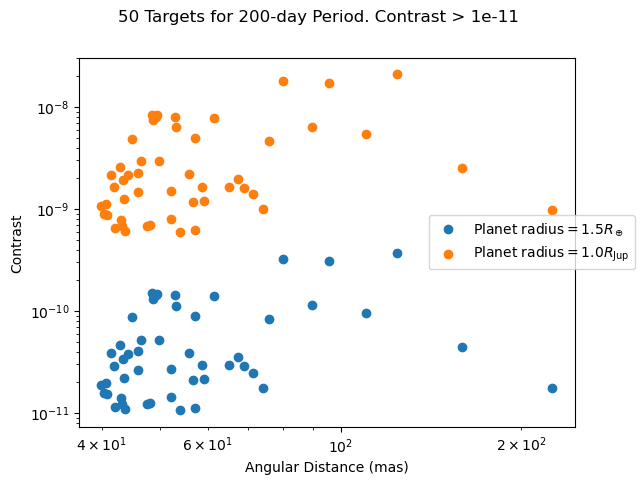

In [482]:
## Period = 200 days
targetSelection = np.array(targetsDF["ContrastSupEarth200.0d"])
targetsContrastCutFor200 = targetsDF[ targetSelection > 1e-11]

fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Angular Distance (mas)")
ax.set_ylabel("Contrast")

ax.scatter(targetsContrastCutFor200["AngularDist200.0d (mas)"], targetsContrastCutFor200["ContrastSupEarth200.0d"], label = "Planet radius$= 1.5R_\\oplus$")
ax.scatter(targetsContrastCutFor200["AngularDist200.0d (mas)"], targetsContrastCutFor200["ContrastJup200.0d"], label = "Planet radius$= 1.0R_{\\text{Jup}}$")

fig.legend(loc="right")

fig.suptitle("{} Targets for 200-day Period. Contrast > 1e-11".format(len(targetsContrastCutFor200)))
plt.show()

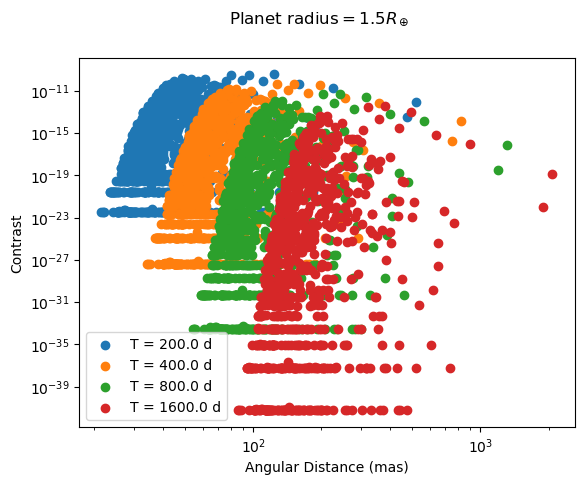

In [377]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Angular Distance (mas)")
ax.set_ylabel("Contrast")

starDistance = np.array(targetsDF["Dist (pc)"])*u.pc
for i in range(len(orbitalPeriods)):
    angularDist = orbitalDistance[i]/starDistance
    angularDist = angularDist.si.value # radians
    angularDist = angularDist * (180/np.pi)*3600*1000
    ax.scatter(angularDist, superEarthContrast[i], label = "T = {}".format(orbitalPeriods[i]))

ax.legend()
fig.suptitle("Planet radius$= 1.5R_\\oplus$")
plt.show()

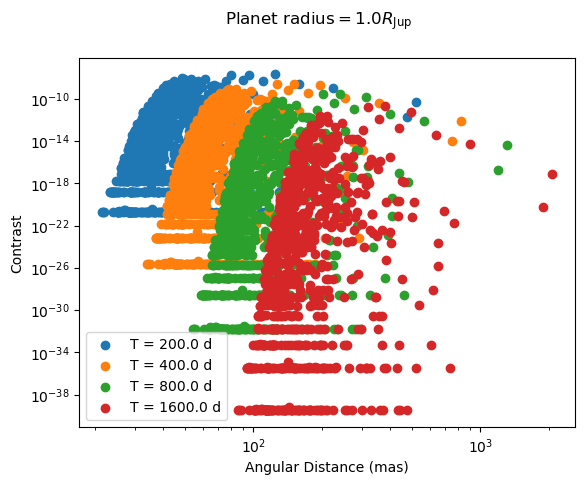

In [381]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Angular Distance (mas)")
ax.set_ylabel("Contrast")

starDistance = np.array(targetsDF["Dist (pc)"])*u.pc
for i in range(len(orbitalPeriods)):
    angularDist = orbitalDistance[i]/starDistance
    angularDist = angularDist.si.value # radians
    angularDist = angularDist * (180/np.pi)*3600*1000
    ax.scatter(angularDist, jupContrast[i], label = "T = {}".format(orbitalPeriods[i]))

ax.legend()
fig.suptitle("Planet radius$= 1.0R_{\\text{Jup}}$")
plt.show()